# DATA VISUALISATION for LSTM Model : dublin bikes and dublin weather  

# Initial Statements, Setup & File access 

Words "Column", "Features", "Feature vectors" are used synonymously to indicate a feature of data.

In [1]:
# Import pandas, numpy, matplotlib, seaborn libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from tabulate import tabulate
import datetime
import tensorflow as tf

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# read in data from csv file to pandas dataframe.  
bikeStatic = pd.read_csv('dBikeS.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
bikeDynamic = pd.read_csv('dBikeD.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
weather = pd.read_csv('dWeatherD.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

# 1. Data Quality Report

 - **Scope of stage 1**
     - Data is not dropped unless for rows are duplicated.
     - Data within a feature is manipulated only with mathematical operation. Data is not altered with reference to data in other features.
     - Null values are not treated/ replaced with a unique name. They are preserved for stage2 operations.

## 1.1 Data view and formatting for Dublin bike dynamic data

### 1.1.1 Check details about number of data samples and attributes in data

In [3]:
bikeDynamic.shape

(369160, 8)

### 1.1.2 List sample head and tail rows of data

#### Sample first 5 rows 

In [4]:
bikeDynamic.head()

,id_Entry,number,status,bike_stands,available_bike_stands,available_bikes,last_update,data_entry_timestamp
0,1745,42,OPEN,30,17,13,2020-02-28 14:55:41,2020-02-28 15:00:04
1,1746,30,OPEN,20,16,4,2020-02-28 14:59:32,2020-02-28 15:00:04
2,1747,54,OPEN,33,22,9,2020-02-28 14:54:01,2020-02-28 15:00:04
3,1748,108,OPEN,40,37,3,2020-02-28 14:59:44,2020-02-28 15:00:04
4,1749,56,OPEN,40,13,27,2020-02-28 14:52:20,2020-02-28 15:00:04


#### Sample last 5 rows 

In [5]:
bikeDynamic.tail()

,id_Entry,number,status,bike_stands,available_bike_stands,available_bikes,last_update,data_entry_timestamp
369155,370900,39,OPEN,20,6,14,2020-03-24 11:37:49,2020-03-24 11:40:02
369156,370901,83,OPEN,40,27,13,2020-03-24 11:35:57,2020-03-24 11:40:02
369157,370902,92,OPEN,40,25,15,2020-03-24 11:38:08,2020-03-24 11:40:02
369158,370903,21,OPEN,30,22,8,2020-03-24 11:31:46,2020-03-24 11:40:02
369159,370904,88,OPEN,30,9,21,2020-03-24 11:35:03,2020-03-24 11:40:02


**Results**:
 - Column "id_Entry" is possibly a key column uniquely identifying a station.
 - No duplicate column pairs are present in lay man observation
 - Spreadsheet program shows that all values logged in database are normal and nothing unregulated found.

**Observation on spreadsheet state that results for date 28 February and 24 March are patial. Hence, they are to be dropped for data consistency.** 

In [6]:
#DATETIME DATA

# Select columns containing datetime data
continous_date_columns = bikeDynamic[['last_update', 'data_entry_timestamp']].columns

# Assign object type datetime to columns enlisted in continous_date_columns
for column in continous_date_columns:
    bikeDynamic[column] = pd.to_datetime(bikeDynamic[column])
    
d1 = datetime.datetime.strptime('2020-03-24 11:37:49','%Y-%m-%d %H:%M:%S')
d2 = datetime.datetime.strptime('2020-02-28 11:37:49','%Y-%m-%d %H:%M:%S')

bikeDynamic = bikeDynamic[(bikeDynamic['data_entry_timestamp'].dt.date != d1.date()) & (bikeDynamic['data_entry_timestamp'].dt.date != d2.date())]

### 1.1.3 Convert features to apropriate data types

#### 1.1.3.1 Count number of distinct values assumed by data for each feature  

In [7]:
# Gather information related to identifiers for instacnes, count of instances and count of unique instances for all features. 
# This information is stored into a csv.  

bikeDynamic_count = pd.DataFrame(
    [column, str(bikeDynamic[column].count()), str(len(bikeDynamic[column].unique())),\
    round((len(bikeDynamic[column].unique()) / bikeDynamic[column].count()),6)] for column in bikeDynamic.columns.values\
    )
bikeDynamic_count.columns = ['Features', 'Instances', 'Unique Instances','unique instances : Total instances']

bikeDynamic_count

,Features,Instances,Unique Instances,unique instances : Total instances
0,id_Entry,355410,355410,1.000000
1,number,355410,110,0.000310
2,status,355410,2,0.000006
3,bike_stands,355410,17,0.000048
4,available_bike_stands,355410,41,0.000115
5,available_bikes,355410,41,0.000115
6,last_update,355410,300353,0.845089
7,data_entry_timestamp,355410,3231,0.009091


#### 1.1.3.2 Enlist preassigned data types 

In [8]:
print(tabulate(pd.DataFrame(bikeDynamic.dtypes), headers=["Feature", "Data Type"]), "\n\n\n")

Feature                Data Type
---------------------  --------------
id_Entry               int64
number                 int64
status                 object
bike_stands            int64
available_bike_stands  int64
available_bikes        int64
last_update            datetime64[ns]
data_entry_timestamp   datetime64[ns] 





#### 1.1.3.3 Decide data types to be assigned to each feature 

 - id_Entry is primary keey for the dataset.
 - Examination of CSV as a spreadsheet helps to **substantiate speculation** about actual data types: <br>

| Features                  | Data Classification| Subtype    | Discription    |
|:------------------------- |:------------------ |:---------- |:-------------- | 
| id_Entry                  | numeric            | discrete | Primary key for database|
| number                    | numeric            | discrete | staion id|
| status                    | catagorical        | nominal    | station is operational or closed |
| bike_stands               | numeric            | discrete   | total number of stands at station|
| available_bike_stands     | numeric            | discrete   | available bikes at station|
| available_bikes           | numeric            | discrete   | available parking slots at station|
| last_update               | datetime           | discrete   | last update to API serivce server by station|
| data_entry_timestamp      | datetime           | discrete   | time of data entry into server; not relevent for analysis|

#### 1.1.3.4 Convert to decided data type 

In [9]:
#CATAGORICAL DATA

# Select columns containing categorical data
categorical_columns = bikeDynamic[['status']].columns

# Assign data type category to columns listed in categorical_columns
for column in categorical_columns:
    bikeDynamic[column] = bikeDynamic[column].astype('category') 

In [10]:
#CONTINUOUS DATA

# Select columns containing continuous data
continous_columns = bikeDynamic[['id_Entry', 'number','bike_stands','available_bike_stands','available_bikes']].columns

# Assign data type int64 to columns listed in continuous_columns
for column in continous_columns:
    bikeDynamic[column] = bikeDynamic[column].astype('int64')

#### 1.1.3.5 Varify correct data type casting of features 

In [11]:
print(tabulate(pd.DataFrame(bikeDynamic.dtypes), headers=["Feature", "Data Type"]), "\n\n\n")

Feature                Data Type
---------------------  --------------
id_Entry               int64
number                 int64
status                 category
bike_stands            int64
available_bike_stands  int64
available_bikes        int64
last_update            datetime64[ns]
data_entry_timestamp   datetime64[ns] 





### 1.1.4 Drop duplicates

In [12]:
# Check for duplicate rows
#Print the number of duplicate rows, without the original rows that were duplicated

# Check for duplicate rows for primary key "id_Entry"
print('Number of duplicate (excluding first) rows in the table is: ', bikeDynamic.duplicated(subset = "id_Entry").sum()) 

# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', bikeDynamic[bikeDynamic.duplicated(subset = "id_Entry",keep=False)].shape[0])


Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


In [13]:
# Check for duplicate columns
#First transpose the df so columns become rows, then apply the same check as above
# Since cardinality of data is huge and ever increasing; and we just need to see if NO DUPLICATES EXIST; hence subset of database is taken.

bikeDynamicT = bikeDynamic.head(1000).T

# Check for duplicate columns.
print("Number of duplicate (excluding first) columns in the table is: ", bikeDynamicT.duplicated().sum())

#Print the number of duplicates, including the original columns that were duplicated
print("Number of duplicate (including first) columns in the table is: ",  bikeDynamicT[bikeDynamicT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  0
Number of duplicate (including first) columns in the table is:  0


**Result : Duplicate columns (features) do exist**
 - Rows : Duplicate samples do not exist. id_Entry has (unique values : total values ratio) = 1. Logically, its a primary key for the dataset. Hence, duplicacies are checked with its respect and none are found.
 - Columns : Duplicate samples do not exist. 

### 1.1.5 Check constant features

#### 1.1.5.1 Catagorical features 

In [14]:
# Print table with categorical statistics
bikeDynamic.select_dtypes(['category']).describe().T

,count,unique,top,freq
status,355410,2,OPEN,355066


**Categorical Data** 
- Reviewing the categorical data below we can see all unique values > 1



#### 1.1.5.2 Continuous features 

In [15]:
# Print table with continuous statistics
bikeDynamic.select_dtypes(include=['int64']).describe().T

,count,mean,std,min,25%,50%,75%,max
id_Entry,355410.0,185389.500000,102598.173924,7685.0,96537.25,185389.5,274241.75,363094.0
number,355410.0,60.518182,33.767631,2.0,31.00,61.5,90.00,117.0
bike_stands,355410.0,32.181818,7.650539,16.0,29.00,30.0,40.00,40.0
available_bike_stands,355410.0,20.249658,10.792020,0.0,12.00,20.0,29.00,40.0
available_bikes,355410.0,11.842146,9.583294,0.0,4.00,10.0,18.00,40.0


**Continuous Data** 
- No continuous feature has a non zero standard deviation.  
- This implies that feature does not contain a single constant value in all of the rows. Thus in this case, none of the continuous features are constant.
- Result - No constant columns

#### 1.1.5.3 DateTime features 

In [16]:
# Print table with continuous statistics
bikeDynamic.select_dtypes(include=['datetime']).describe().T

,count,unique,top,freq,first,last
last_update,355410,300353,2020-03-13 21:14:38,116,2020-02-28 22:57:37,2020-03-23 23:49:05
data_entry_timestamp,355410,3231,2020-03-19 03:40:02,110,2020-02-29 00:00:06,2020-03-23 23:50:02


**DateTime Data** 
- Reviewing the datetime data below we can see all unique values > 1 

Though this is not catagorical data, it is valid to say that last_update being same for multiple stations is a likely possibility. So is case for data_entry_timestamp; which represents time of data entry into database by data scraper.

**Result : No constant Features found in dataset**

### 1.1.6 Check for null values in features

In [17]:
print("Features".ljust(20," "),"Null instances","\n\n")
bikeDynamic.isnull().sum()

Features             Null instances 




id_Entry                 0
number                   0
status                   0
bike_stands              0
available_bike_stands    0
available_bikes          0
last_update              0
data_entry_timestamp     0
dtype: int64

**Result : No null values found**

## 1.2 Data cleansing and discriptive statistics

### 1.2.1 Varify cardinality 

#### 1.2.1.1 Catagorical features 

In [18]:
# Check for irregular cardinality & permitted values in categorical features.
columns = list(bikeDynamic.select_dtypes(['category']).columns.values)
for column in columns: 
    print("Feature:",column,"\tCardinality:",str(len(bikeDynamic[column].unique())),"\n",pd.unique(bikeDynamic[column].ravel()),"\n\n")

Feature: status 	Cardinality: 2 
 [OPEN, CLOSED]
Categories (2, object): [OPEN, CLOSED] 




In [19]:
# For each catagorical feature, display the number of instances each of its values has.
columns = list(bikeDynamic.select_dtypes(['category']).columns.values)
for column in columns:
    featureDetail = column+"   Cardinality:"+str(len(bikeDynamic[column].unique()))
    print(featureDetail,"\n{}\n".format('-'*len(str(featureDetail))))
    print(tabulate(pd.DataFrame(bikeDynamic[column].value_counts().nlargest(15)), headers=["Instance", "Number of Instances"]), "\n\n\n")


status   Cardinality:2 
----------------------

Instance      Number of Instances
----------  ---------------------
OPEN                       355066
CLOSED                        344 





**Values of cardinality of catagorical features are regular and within normal consideration.** 
 - Almost stations are 'OPEN'.
 - Only 0.1% times station entry is 'CLOSED'

#### 1.2.1.2 Continuous features 

In [20]:
# Check for irregular cardinality & permitted values in continuous features.
columns = list(bikeDynamic.select_dtypes(['int64']).columns.values)
for column in columns: 
    print("Feature:",column,"\tCardinality:",str(len(bikeDynamic[column].unique())),"\n",pd.unique(sorted(bikeDynamic[column].ravel())),"\n\n\n")

Feature: id_Entry 	Cardinality: 355410 
 [  7685   7686   7687 ... 363092 363093 363094] 



Feature: number 	Cardinality: 110 
 [  2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  36  37  38  39  40
  41  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57  58  59
  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117] 



Feature: bike_stands 	Cardinality: 17 
 [16 20 21 22 23 24 25 27 29 30 31 32 33 35 36 38 40] 



Feature: available_bike_stands 	Cardinality: 41 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 



Feature: available_bikes 	Cardinality: 41 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 

In [21]:
# For each continuous feature, display the number of instances each of its values has.
columns = list(bikeDynamic.select_dtypes(['int64']).columns.values)
for column in columns:
    print(column,"\n{}\n".format('-'*len(str(column))))
    print(tabulate(pd.DataFrame(bikeDynamic[column].value_counts().nlargest(15)), headers=["Feature", "Number of Instances"]), "\n\n\n")


id_Entry 
--------

  Feature    Number of Instances
---------  ---------------------
     8188                      1
   287449                      1
   271057                      1
   277202                      1
   275155                      1
   264916                      1
   262869                      1
   269014                      1
   266967                      1
   289496                      1
   293594                      1
   316111                      1
   291547                      1
   281308                      1
   279261                      1 



number 
------

  Feature    Number of Instances
---------  ---------------------
      117                   3231
       45                   3231
       33                   3231
       34                   3231
       36                   3231
       37                   3231
       38                   3231
       39                   3231
       40                   3231
       41                   3231
   

**Values of cardinality of Continuous features are regular and within normal consideration.** 
 - No irregularity is found
 - Refering to quartile ranges and permissible values, it is evident that for both bike_stands, available_bike_stands and available_bikes features: 
     - On average, nearly 35% of stands have 0 available bikes at any time
     - 70% Bike stands have capacity greater than 29; 39% Bike stands have capcity of 40 bikes

#### 1.2.1.3 DateTime features 

In [22]:
# Check for irregular cardinality & permitted values in datetime features.
columns = list(bikeDynamic.select_dtypes(['datetime64']).columns.values)
for column in columns: 
    print("Feature:",column,"\tCardinality:",str(len(bikeDynamic[column].unique())),"\n",pd.unique(sorted(bikeDynamic[column].ravel())),"\n\n\n")

Feature: last_update 	Cardinality: 300353 
 ['2020-02-28T22:57:37.000000000' '2020-02-28T23:50:00.000000000'
 '2020-02-28T23:50:12.000000000' ... '2020-03-23T23:48:59.000000000'
 '2020-03-23T23:49:02.000000000' '2020-03-23T23:49:05.000000000'] 



Feature: data_entry_timestamp 	Cardinality: 3231 
 ['2020-02-29T00:00:06.000000000' '2020-02-29T00:10:02.000000000'
 '2020-02-29T00:20:02.000000000' ... '2020-03-23T23:30:02.000000000'
 '2020-03-23T23:40:02.000000000' '2020-03-23T23:50:02.000000000'] 





In [23]:
# For each datetime feature, display the number of instances each of its values has.
columns = list(bikeDynamic.select_dtypes(['datetime64']).columns.values)
for column in columns:
    print(column,"\n{}\n".format('-'*len(str(column))))
    print(tabulate(pd.DataFrame(bikeDynamic[column].value_counts().nlargest(10)), headers=["Feature", "Number of Instances"]), "\n\n\n")


last_update 
-----------

Feature                Number of Instances
-------------------  ---------------------
2020-03-13 21:14:38                    116
2020-03-06 19:32:44                     41
2020-03-14 04:06:25                     40
2020-03-16 03:55:32                     21
2020-03-16 19:33:46                     18
2020-03-12 15:31:12                     16
2020-03-16 03:55:04                     15
2020-03-16 03:59:52                     15
2020-03-13 06:58:33                     15
2020-03-16 03:54:54                     14 



data_entry_timestamp 
--------------------

Feature                Number of Instances
-------------------  ---------------------
2020-03-19 03:40:02                    110
2020-03-07 22:30:02                    110
2020-03-07 07:30:02                    110
2020-03-07 05:00:04                    110
2020-03-16 00:00:05                    110
2020-03-15 20:20:02                    110
2020-03-18 06:40:02                    110
2020-03-04 23:50:02    

**Values of cardinality of DateTime features are regular and within normal consideration.** 
- As expected, data_entry_timestamp has fixed number of instances for each entry since data is entered for each station exactly once
- last_update feature shows 116 instances for a perticular "2020-03-13 21:14:38" which is an eye catcher.

### 1.2.2 Check logical integrity of data 

**Data integrity is checked for following cases:**
 - is "bike_stands" $>=$ "available_bike_stands" $+$ "available_bikes"  [Any other sequence is incorrect]
 - is "last_update" $<=$ "data_entry_timestamp" [Any other sequence is incorrect]

Date of birth for an animal must always be smaller than or equal to date of intake into shelter.

In [24]:
test_1 = bikeDynamic[["available_bike_stands","available_bikes","bike_stands"]][bikeDynamic["available_bike_stands"].add(bikeDynamic["available_bikes"], axis=0)  >  bikeDynamic["bike_stands"]]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(5)

Number of rows failing the test:  18


,available_bike_stands,available_bikes,bike_stands
63885,17,0,16
248795,16,1,16
248905,16,1,16
249125,16,1,16
249235,16,1,16


Date of birth for an animal must always be smaller than or equal to date of Outcome from shelter.

In [25]:
test_2 = bikeDynamic[["last_update","data_entry_timestamp"]][bikeDynamic["data_entry_timestamp"]  <  bikeDynamic["last_update"]]
print("Number of rows failing the test: ", test_2.shape[0])
test_2.head(5)

Number of rows failing the test:  0


,last_update,data_entry_timestamp


### 1.2.3  Save discriptive statistics into CSV for data quality report

#### 1.2.3.1 Discriptive statistics for Catagorical Data

In [26]:
# Print table with categorical statistics and preserve in a csv
dStat_catagorical = bikeDynamic.select_dtypes(['category']).describe().T
dStat_catagorical.to_csv("categoricalFeatureDescription.csv")
dStat_catagorical

,count,unique,top,freq
status,355410,2,OPEN,355066


#### 1.2.3.2 Discriptive statistics for Continuous Data

In [27]:
# Print table with continuous statistics and preserve in a csv
dStat_continuous = bikeDynamic.select_dtypes(['int64']).describe().T
dStat_continuous.to_csv("continuousFeatureDescription.csv")
dStat_continuous

,count,mean,std,min,25%,50%,75%,max
id_Entry,355410.0,185389.500000,102598.173924,7685.0,96537.25,185389.5,274241.75,363094.0
number,355410.0,60.518182,33.767631,2.0,31.00,61.5,90.00,117.0
bike_stands,355410.0,32.181818,7.650539,16.0,29.00,30.0,40.00,40.0
available_bike_stands,355410.0,20.249658,10.792020,0.0,12.00,20.0,29.00,40.0
available_bikes,355410.0,11.842146,9.583294,0.0,4.00,10.0,18.00,40.0


#### 1.2.3.3 Discriptive statistics for DateTime Data

#### 1.2.3.4 Save final CSV from stage 1

In [28]:
# Print table with datetime statistics and preserve in a csv
dStat_datetime = bikeDynamic.select_dtypes(['datetime64']).describe().T
dStat_datetime.to_csv("datetimeFeatureDescription.csv")
dStat_datetime

,count,unique,top,freq,first,last
last_update,355410,300353,2020-03-13 21:14:38,116,2020-02-28 22:57:37,2020-03-23 23:49:05
data_entry_timestamp,355410,3231,2020-03-19 03:40:02,110,2020-02-29 00:00:06,2020-03-23 23:50:02


## 1.3 Graphs 

### 1.3.1 Save Histogram summary sheets for Continuous features into  pdf file

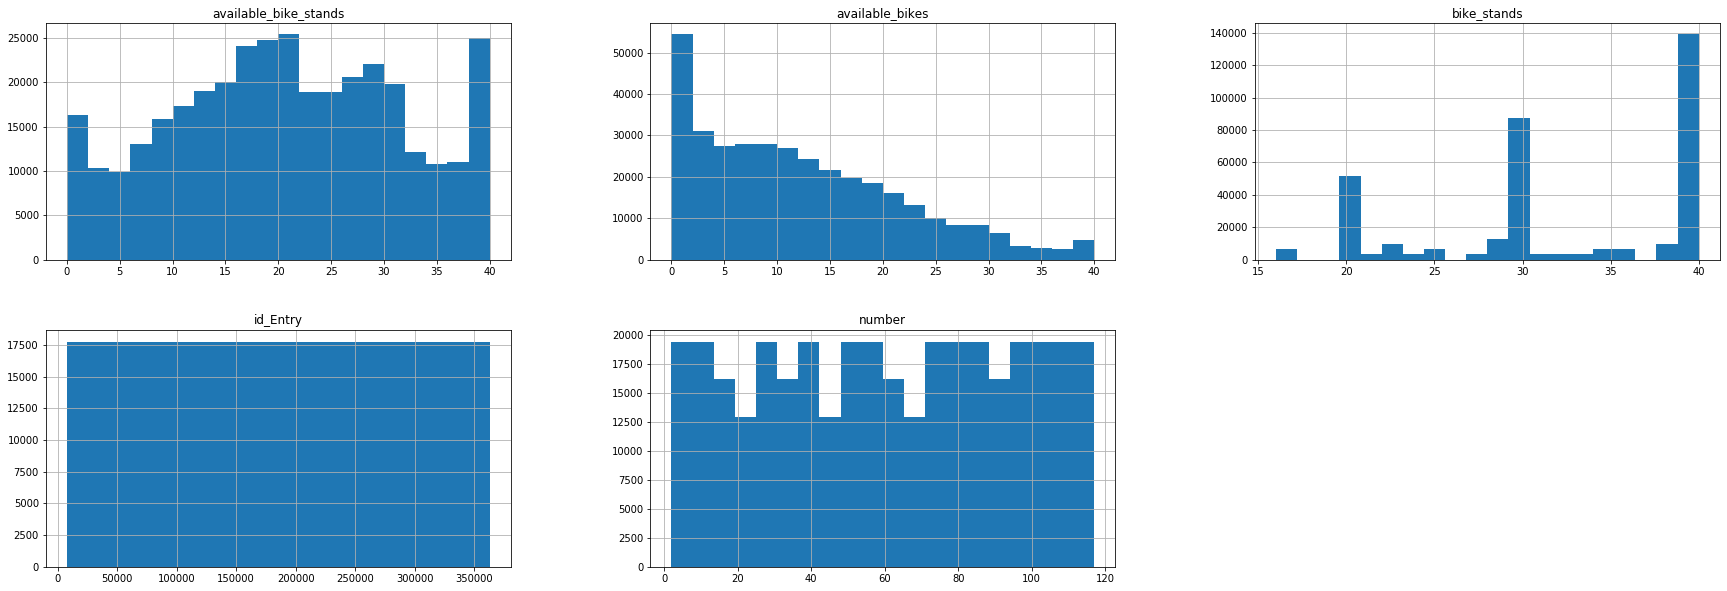

In [29]:
# Plot a histogram summary sheet of the continuous features and save in a pdf file
columns = list(bikeDynamic.select_dtypes(['int64']).columns.values)
bikeDynamic[columns].hist(layout=(2, 3), figsize=(30,10), bins=20)
plt.savefig('continuous_histograms_1-1.pdf')

### 1.3.2 Save Box plot summary sheets for Continuous features into pdf file

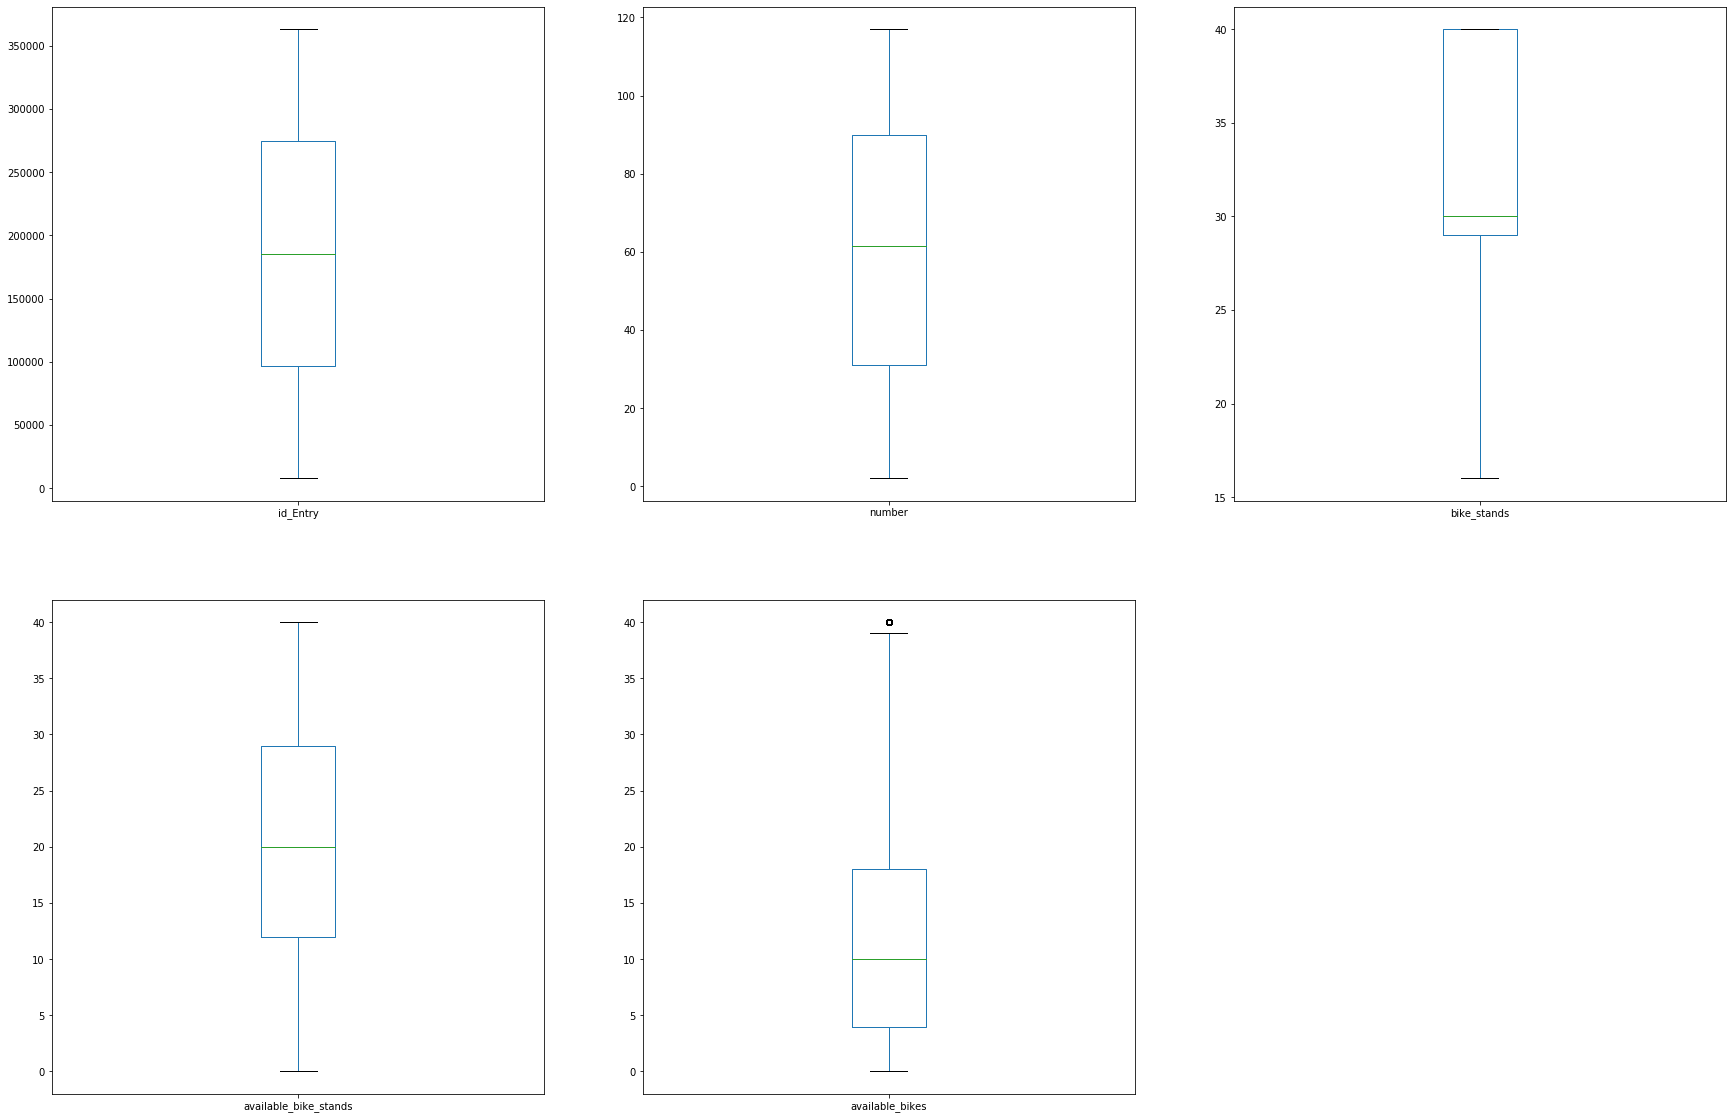

In [30]:
# Plot a histogram summary sheet of the continuous features and save in a pdf file
columns = list(bikeDynamic.select_dtypes(['int64']).columns.values)
bikeDynamic[columns].plot(kind='box', subplots=True, figsize=(30,20), layout=(2,3), sharex=False, sharey=False)
plt.savefig('continuous_box_1-1.pdf')

### 1.3.5 Save Bar plot summary sheets for Catagorical features into pdf file

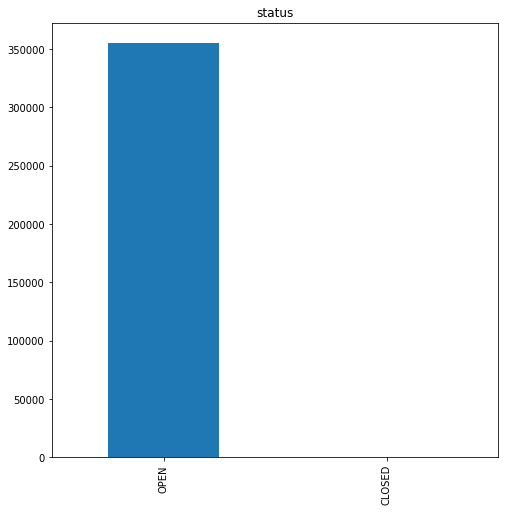

In [31]:
# Plot bar plots for all the catagorical features and save them in a single PDF file
columns = list(bikeDynamic.select_dtypes(['category']).columns.values)
with PdfPages('categorical_bar_1-1.pdf') as pp:
    for column in columns:
        f = bikeDynamic[column].value_counts().plot(kind='bar', figsize=(8,8))
        plt.title(column)
        pp.savefig(f.get_figure())
        plt.show()

# 2. Data Quality Plan

## 2.1 Data findings  

### 2.1.1 Summary of list of issues found in Data Quality Report  

- test_1 states that 18 entries have bad data regarding total number of bike stands at a station.


### 2.1.2 Proposed solutions to rectify identified problems   

- Replace feature bike_stands with value sum of available_bike_stands,available_bikes  

## 2.2 Apply solutions to address data quality issues

### 2.2.1 DateTime Intake > DateTime Outcome

In [32]:
dTest = bikeDynamic[["id_Entry","available_bike_stands","available_bikes","bike_stands"]][bikeDynamic["available_bike_stands"].add(bikeDynamic["available_bikes"], axis=0)  >  bikeDynamic["bike_stands"]]
print("Number of rows failing the test: ", dTest.shape[0])
dTest.head(5)

Number of rows failing the test:  18


,id_Entry,available_bike_stands,available_bikes,bike_stands
63885,65630,17,0,16
248795,250540,16,1,16
248905,250650,16,1,16
249125,250870,16,1,16
249235,250980,16,1,16


**Replacing corresponding entries for feature "bike_stands":**

In [33]:
dTest_1 = dTest["id_Entry"]

for data in dTest_1: 
    bikeDynamic.loc[(bikeDynamic.id_Entry == data),'bike_stands'] = bikeDynamic.loc[(bikeDynamic.id_Entry == data),'available_bikes'] + bikeDynamic.loc[(bikeDynamic.id_Entry == data),'available_bike_stands']

In [34]:
dTest = bikeDynamic[["id_Entry","available_bike_stands","available_bikes","bike_stands"]][bikeDynamic["available_bike_stands"].add(bikeDynamic["available_bikes"], axis=0)  >  bikeDynamic["bike_stands"]]
print("Number of rows failing the test: ", dTest.shape[0])
dTest.head(5)

Number of rows failing the test:  0


,id_Entry,available_bike_stands,available_bikes,bike_stands


## 2.3 Summary of data quality plan



| Feature                  | Data Quality issue | Solution Strategy    |
|:-------------------------|:------------------ |:---------- | 
| id_Entry                 | [Primary key]      | Do nothing    |
| number                   | Nothing            | Do nothing    |
| status                   | Nothing            | Do nothing    |
| bike_stands              | Value inconsistancy for 18 entires | increment by 1|
| available_bike_stands    | Nothing            | Do nothing    |
| available_bikes          | Nothing            | Do nothing    |
| last_update              | Nothing            | Do nothing    |
| data_entry_timestamp     | Nothing            | Do nothing    |


## 2.4 Save cleaned data to new CSV 

In [35]:
bikeDynamic.to_csv('dBikeD_2.4_cleaned.csv', index=False, index_label = True)

# 3. Feature Exploration

## 3.1 Time series view 

In [36]:
bikeDynamicTS = bikeDynamic
bikeDynamicTS['date_UTC'] = [datetime.datetime.timestamp(d) for d in bikeDynamicTS['data_entry_timestamp']]
bikeDynamicTS['dayNumber'] = bikeDynamicTS['data_entry_timestamp'].dt.dayofweek
bikeDynamicTS.head()

,id_Entry,number,status,bike_stands,available_bike_stands,available_bikes,last_update,data_entry_timestamp,date_UTC,dayNumber
5940,7685,42,OPEN,30,10,20,2020-02-28 23:52:29,2020-02-29 00:00:06,1.582934e+09,5
5941,7686,30,OPEN,20,20,0,2020-02-28 23:53:40,2020-02-29 00:00:06,1.582934e+09,5
5942,7687,54,OPEN,33,29,4,2020-02-28 23:54:52,2020-02-29 00:00:06,1.582934e+09,5
5943,7688,108,OPEN,40,31,9,2020-02-28 22:57:37,2020-02-29 00:00:06,1.582934e+09,5
5944,7689,56,OPEN,40,37,3,2020-02-28 23:50:26,2020-02-29 00:00:06,1.582934e+09,5


In [37]:
bikeDynamic.to_csv('dBikeD_3.1_1_cleaned.csv', index=False, index_label = True)

In [38]:
dates = [datetime.datetime.fromtimestamp(timestamp) for timestamp in bikeDynamicTS['date_UTC'].unique()]

In [39]:
stationNumbers = bikeDynamicTS['number'].unique()
timeT = []
available_bike_stands = []

for station in stationNumbers:
    tempTime = bikeDynamicTS.loc[(bikeDynamicTS.number == station)]['date_UTC'].values.tolist()
    tempStands = bikeDynamicTS.loc[(bikeDynamicTS.number == station)]['available_bike_stands'].values.tolist() 
    timeT.append(tempTime)
    available_bike_stands.append(tempStands)

## Bikestand availability for a day
 - **As seen, weekday traffic experiences a definite cycle**
 - **Weekend traffic is not heavy**
 <br><br>
 
### Due to COVID 19 situation, "Stay at home" directive from Government of Ireland was applied in last week of March 2020. dublin bike usage was unnaturlly altered which can be seen at end of time series.

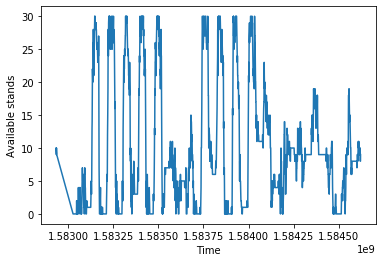

In [40]:
# Split data into training and testing data. Display train data
time,series = timeT[0],available_bike_stands[0]

tLen = len(time)
split_time = tLen - int(tLen*0.2) 
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.plot(time_train, x_train)
# plt.xticks(range(len(time_train)), time_train)
plt.xlabel('Time')
plt.ylabel('Available stands')
plt.show()

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [41]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Train LSTM model

In [43]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=30, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
26/26 [==============================] - 3s 133ms/step - loss: 10.2887 - mae: 10.8553
Epoch 2/150
26/26 [==============================] - 1s 40ms/step - loss: 3.1384 - mae: 3.6088
Epoch 3/150
26/26 [==============================] - 1s 37ms/step - loss: 2.2388 - mae: 2.6825
Epoch 4/150
26/26 [==============================] - 1s 42ms/step - loss: 1.9057 - mae: 2.3398
Epoch 5/150
26/26 [==============================] - 1s 45ms/step - loss: 1.7339 - mae: 2.1562
Epoch 6/150
26/26 [==============================] - 1s 41ms/step - loss: 1.6007 - mae: 2.0108
Epoch 7/150
26/26 [==============================] - 1s 39ms/step - loss: 1.5075 - mae: 1.9267
Epoch 8/150
26/26 [==============================] - 1s 46ms/step - loss: 1.4087 - mae: 1.8221
Epoch 9/150
26/26 [==============================] - 1s 44ms/step - loss: 1.3426 - mae: 1.7530
Epoch 10/150
26/26 [==============================] - 1s 41ms/step - loss: 1.2910 - mae: 1.7021
Epoch 11/150
26/26 [==========================

26/26 [==============================] - 1s 39ms/step - loss: 0.6814 - mae: 1.0359
Epoch 87/150
26/26 [==============================] - 1s 37ms/step - loss: 0.6831 - mae: 1.0385
Epoch 88/150
26/26 [==============================] - 1s 37ms/step - loss: 0.6896 - mae: 1.0509
Epoch 89/150
26/26 [==============================] - 1s 38ms/step - loss: 0.6856 - mae: 1.0452
Epoch 90/150
26/26 [==============================] - 1s 39ms/step - loss: 0.6825 - mae: 1.0396
Epoch 91/150
26/26 [==============================] - 1s 38ms/step - loss: 0.6802 - mae: 1.0358
Epoch 92/150
26/26 [==============================] - 1s 40ms/step - loss: 0.6911 - mae: 1.0511
Epoch 93/150
26/26 [==============================] - 1s 38ms/step - loss: 0.6994 - mae: 1.0628
Epoch 94/150
26/26 [==============================] - 1s 38ms/step - loss: 0.6678 - mae: 1.0208
Epoch 95/150
26/26 [==============================] - 1s 39ms/step - loss: 0.6652 - mae: 1.0162
Epoch 96/150
26/26 [==============================] -

## Forecast results for validation data and compare performance metrics

In [44]:
series = np.asarray(series)
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

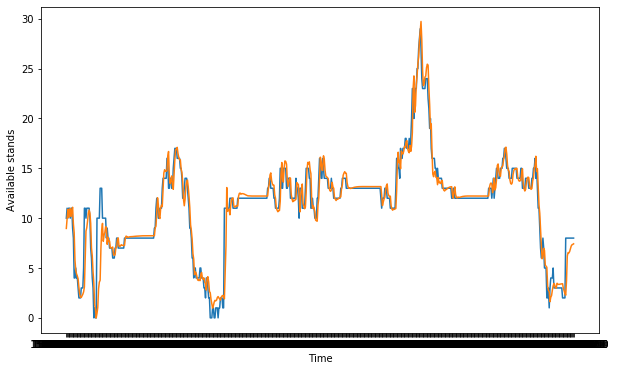

In [46]:
plt.figure(figsize=(10, 6))

plt.plot(x_valid)
plt.xticks(range(len(time_valid)), time_valid)
plt.xlabel('Time')
plt.ylabel('Available stands')

plt.plot(rnn_forecast)
plt.xticks(range(len(time_valid)), time_valid)
plt.xlabel('Time')
plt.ylabel('Available stands')

plt.show()



## Prediction performance metrics

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.8108871

<Figure size 432x288 with 0 Axes>

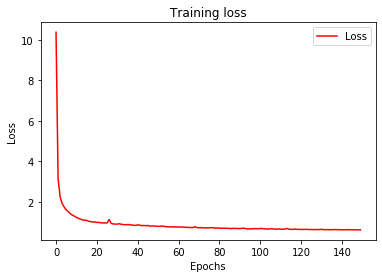

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()


## Save Model

In [50]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
